In [57]:
import pickle
import seaborn as sns
import pandas as pd
import os

In [59]:
results = []
task = "sirsde"
results_dir = "../results/sirsde/"
for f_name in sorted(os.listdir(results_dir))[1:]:
    if ".pickle" in f_name:
        with open(results_dir + f_name, "rb") as f:
            results.append(pickle.load(f))

In [60]:
df = pd.DataFrame({
    False: [r["no_error_model_logprob_theta_true"] for r in results],
    True: [r["error_model_logprob_theta_true"] for r in results]
})
df = df.sort_values(False)

assert len(df) == 1000

AssertionError: 

<AxesSubplot:xlabel='error model', ylabel='logprob theta*'>

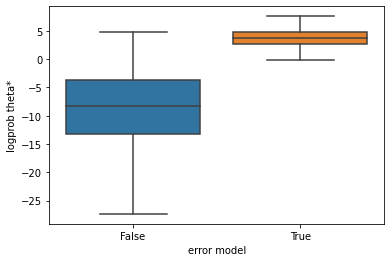

In [77]:
# See nested grouping example in https://seaborn.pydata.org/generated/seaborn.boxplot.html ? if log probs on similar scale
sns.boxplot(
    x = "error model",
    y = "logprob theta*",
    showfliers=False,
    data=df.melt(var_name="error model", value_name="logprob theta*"))


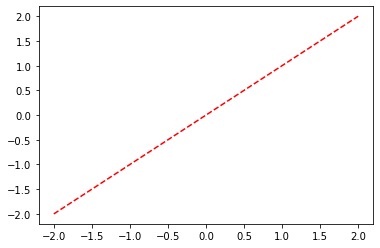

[]

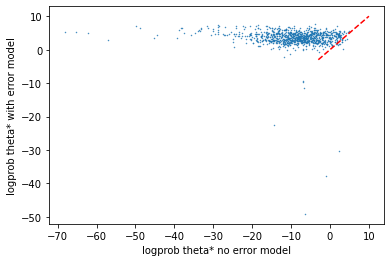

In [63]:
import matplotlib.pyplot as plt
plt.scatter(df[False], df[True], s=0.2)
plt.xlabel("logprob theta* no error model")
plt.ylabel("logprob theta* with error model")
plt.plot([-3, 10], [-3, 10], linestyle='--', color="r")
plt.plot()